In [1]:
!pip install git+https://github.com/PyFstat/PyFstat@python37
!pip3 install timm -q
!pip install Pillow
!pip install torchsummary


  Cloning https://github.com/PyFstat/PyFstat (to revision python37) to /tmp/pip-req-build-jc32qi_3
  Running command git clone --filter=blob:none --quiet https://github.com/PyFstat/PyFstat /tmp/pip-req-build-jc32qi_3
  Running command git checkout -b python37 --track origin/python37
  Switched to a new branch 'python37'
  Branch 'python37' set up to track remote branch 'python37' from 'origin'.
  Resolved https://github.com/PyFstat/PyFstat to commit 73ad1acdc9385a234727abf3eb9f93c9298fc5e5
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 409.3 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 MB 18.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from glob import glob
import os
import sys
import h5py
from pathlib import Path
from PIL import Image

import pyfstat
from pyfstat.utils import get_sft_as_arrays
import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as transforms
import timm

from tqdm.auto import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from timm.scheduler import CosineLRScheduler
from sklearn.preprocessing import StandardScaler
import torchsummary
sc=StandardScaler()
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion=nn.BCEWithLogitsLoss()
#criterion=nn.CrossEntropyLoss()
%matplotlib inline
print(device)

cpu


In [3]:
"""
Utils
=====
Utility functions to simplify tutorials.
"""
from matplotlib import colors
from scipy import stats

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 20


def plot_real_imag_spectrograms(timestamps, frequency, fourier_data):
    fig, axs = plt.subplots(1, 2, figsize=(16, 10))

    for ax in axs:
        ax.set(xlabel="SFT index", ylabel="Frequency [Hz]")

    time_in_days = (timestamps - timestamps[0]) / 1800

    axs[0].set_title("SFT Real part")
    c = axs[0].pcolormesh(
        time_in_days,
        frequency,
        fourier_data.real,
        norm=colors.CenteredNorm(),
    )
    fig.colorbar(c, ax=axs[0], orientation="horizontal", label="Fourier Amplitude")

    axs[1].set_title("SFT Imaginary part")
    c = axs[1].pcolormesh(
        time_in_days,
        frequency,
        fourier_data.imag,
        norm=colors.CenteredNorm(),
    )

    fig.colorbar(c, ax=axs[1], orientation="horizontal", label="Fourier Amplitude")

    return fig, axs


def plot_real_imag_spectrograms_with_gaps(timestamps, frequency, fourier_data, Tsft):

    # Fill up gaps with Nans
    gap_length = timestamps[1:] - (timestamps[:-1] + Tsft)

    gap_data = [fourier_data[:, 0]]
    gap_timestamps = [timestamps[0]]

    for ind, gap in enumerate(gap_length):
        if gap > 0:
            gap_data.append(np.full_like(fourier_data[:, ind], np.nan + 1j * np.nan))
            gap_timestamps.append(timestamps[ind] + Tsft)

        gap_data.append(fourier_data[:, ind + 1])
        gap_timestamps.append(timestamps[ind + 1])

    return plot_real_imag_spectrograms(
        np.hstack(gap_timestamps), frequency, np.vstack(gap_data).T
    )

def size_of_spectrograms_with_gaps(timestamps,frequency,fourier_data,Tsft):
    gap_length=timestamps[1:]-(timestamps[:-1]+Tsft)
    gap_data=[fourier_data[:,0]]
    gap_timestamps=[timestamps[0]]
    for ind, gap in enumerate(gap_length):
        if gap > 0:
            gap_data.append(np.full_like(fourier_data[:, ind], np.nan + 1j * np.nan))
            gap_timestamps.append(timestamps[ind] + Tsft)

        gap_data.append(fourier_data[:, ind + 1])
        gap_timestamps.append(timestamps[ind + 1])
    np_array=np.array(gap_data)
    return np_array.shape
    
    
def plot_real_imag_histogram(fourier_data, theoretical_stdev=None):

    fig, ax = plt.subplots(figsize=(16, 10))
    ax.set(xlabel="SFT value", ylabel="PDF", yscale="log")

    ax.hist(
        fourier_data.real.ravel(),
        density=True,
        bins="auto",
        histtype="step",
        lw=2,
        label="Real part",
    )
    ax.hist(
        fourier_data.imag.ravel(),
        density=True,
        bins="auto",
        histtype="step",
        lw=2,
        label="Imaginary part",
    )

    if theoretical_stdev is not None:
        x = np.linspace(-4 * theoretical_stdev, 4 * theoretical_stdev, 1000)
        y = stats.norm(scale=theoretical_stdev).pdf(x)
        ax.plot(x, y, color="black", ls="--", label="Gaussian distribution")

    ax.legend()

    return fig, ax


def plot_amplitude_phase_spectrograms(timestamps, frequency, fourier_data):
    fig, axs = plt.subplots(1, 2, figsize=(16, 10))

    for ax in axs:
        ax.set(xlabel="SFT index", ylabel="Frequency [Hz]")

    time_in_days = (timestamps - timestamps[0]) / 1800

    axs[0].set_title("SFT absolute value")
    c = axs[0].pcolorfast(
        time_in_days, frequency, np.absolute(fourier_data), norm=colors.Normalize()
    )
    fig.colorbar(c, ax=axs[0], orientation="horizontal", label="Value")

    axs[1].set_title("SFT phase")
    c = axs[1].pcolorfast(
        time_in_days, frequency, np.angle(fourier_data), norm=colors.CenteredNorm()
    )

    fig.colorbar(c, ax=axs[1], orientation="horizontal", label="Value")

    return fig, axs

In [4]:
DIR='../input/g2net-detecting-continuous-gravitational-waves'
df=pd.read_csv(DIR+'/train_labels.csv')

def read_hdf5(file: Path):
    with h5py.File(file,"r") as f:
        key=list(f.keys())[0]
        group1=f[key]
        group11=group1[list(group1.keys())[0]]
        group12=group1[list(group1.keys())[1]]
        frequency_Hz=group1["frequency_Hz"][()]
        H1_SFTs=group11["SFTs"][()]
        H1_timestamps_GPS=group11["timestamps_GPS"][()]
        L1_SFTs=group12["SFTs"][()]
        L1_timestamps_GPS=group12["timestamps_GPS"][()]
        return {
            "H1": [H1_SFTs,H1_timestamps_GPS],
            "L1": [L1_SFTs,L1_timestamps_GPS],
            "freq_Hz": frequency_Hz
        }
df.head(15)

,id,target
0,001121a05,1
1,004f23b2d,1
2,00a6db666,1
3,00f36a6ac,1
4,010a387db,1
5,0197bacf8,1
6,01b8b67f3,1
7,01bcf6533,0
8,01dba9731,1
9,021248995,1


In [5]:
DIR='../input/g2net-detecting-continuous-gravitational-waves'
df=pd.read_csv(DIR+'/train_labels.csv')
df=df[df["target"]!=-1]
print(len(df))

600


In [6]:

flip_rate=0.5
mask_rate= 0.3 
time_mask_num= 2
freq_mask_num = 1
Time_Mask=transforms.TimeMasking(time_mask_param=10)
Freq_Mask=transforms.FrequencyMasking(freq_mask_param=10)
            

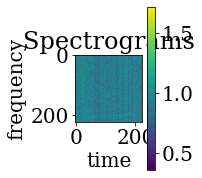

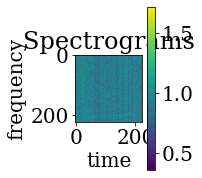

In [7]:
class Dataset(torch.utils.data.Dataset):
    """
    dataset=Dataset(data_type,df)
    
    img, y = dataset[i]
        img (np.float32):
        y (np.float32): label 0 or 1
    """
    def __init__(self,data_type,df,tfms=False):
        self.data_type=data_type
        self.df=df
        self.tfms=tfms
        self.Horizontal=256
    
    def __len__(self):
        return len(self.df)
    
    def read_hdf5_data(self,id):
        file='../input/g2net-detecting-continuous-gravitational-waves/'+self.data_type+'/'+id+'.hdf5'
        return read_hdf5(Path(file))
        
#         with h5py.File(file,"r") as f:
#             key=list(f.keys())[0]
#             group1=f[key]
#             group11=group1[list(group1.keys())[0]]
#             group12=group1[list(group1.keys())[1]]
#             frequency_Hz=group1["frequency_Hz"][()]
#             H1_SFTs=group11["SFTs"][()]
#             H1_timestamps_GPS=group11["timestamps_GPS"][()]
#             L1_SFTs=group12["SFTs"][()]
#             L1_timestamps_GPS=group12["timestamps_GPS"][()]
#             return {
#                 "H1": [H1_SFTs,H1_timestamps_GPS],
#                 "L1": [L1_SFTs,L1_timestamps_GPS],
#                 "freq_Hz": frequency_Hz
#             }
    def get_spectrograms_with_gaps(self,timestamps,frequency,fourier_data,Tsft):
        #print(fourier_data.shape)
        fourier_data=fourier_data* 1e22
        fourier_data=(fourier_data.real**2+np.abs(fourier_data.imag**2))
        fourier_data/=np.mean(fourier_data)
        
#         gap_data=fourier_data.transpose()
        gap_length=timestamps[1:]-(timestamps[:-1]+Tsft)
        gap_data=[fourier_data[:,0]]
        #gap_data=np.array(fourier_data[:,0])
        #print(gap_data.shape)
        gap_timestamps=[timestamps[0]]
        for ind, gap in enumerate(gap_length):
            if gap > 0:
                #print(ind)
                gap_data.append(np.full_like(fourier_data[:, ind], 0))
                #gap_data.append(np.full_like(fourier_data[:, ind], np.nan + 1j * np.nan))
                #gap_data.append(np.full_like(fourier_data[:, ind], np.nan ))
                gap_timestamps.append(timestamps[ind] + Tsft)

            gap_data.append(fourier_data[:, ind + 1])
            gap_timestamps.append(timestamps[ind + 1])
        
        
        
        
        np_array=np.array(gap_data).transpose()
        #print(np_array.shape)
        np_array=np_array[:,:4096]
        #np_array=np.mean(np_array.reshape(360,self.Horizontal,int(4096/self.Horizontal)),axis=2)
        #print(np.hstack(np_array).shape)
        #return np_array
        return np.array(Image.fromarray(np_array).resize((224,224)))
    def __getitem__(self, i):
        row=self.df.iloc[i]
        y=np.int64(row.target)
        file_id=row.id
        data=self.read_hdf5_data(file_id)
        h1_sft,h1_ts=data["H1"]
        l1_sft,l1_ts=data["L1"]
        freq_hz=data["freq_Hz"]
        #plot_real_imag_spectrograms_with_gaps(h1_ts,freq_hz,h1_sft,1800)
        #img=np.empty((2,360,self.Horizontal),dtype=np.float32)
        img=np.empty((2,224,224),dtype=np.float32)
        
        img[0]=(self.get_spectrograms_with_gaps(h1_ts,freq_hz,h1_sft,1800))#-np.min(img[0])
        img[1]=(self.get_spectrograms_with_gaps(l1_ts,freq_hz,l1_sft,1800))#-np.min(img[1])
        
        #img[0]=sc.fit_transform(self.get_spectrograms_with_gaps(h1_ts,freq_hz,h1_sft,1800))-np.min(img[0])
        #img[1]=sc.fit_transform(self.get_spectrograms_with_gaps(l1_ts,freq_hz,l1_sft,1800))-np.min(img[1])
        #img=sc.fit_transform(img)
        if self.tfms:
            if np.random.rand()<=flip_rate:
                img=np.flip(img,axis=1).copy()
            if np.random.rand()<=flip_rate:
                img=np.flip(img,axis=2).copy()
            img=torch.from_numpy(img)
            for _ in range(time_mask_num):
                if np.random.rand()<=mask_rate:
                    img=Time_Mask(img)
            for _ in range(freq_mask_num):
                if np.random.rand()<=mask_rate:
                    img=Freq_Mask(img)
        else:
            img=torch.from_numpy(img)
        #sc.fit_transform(img)
        #img[0]=sc.fit_transform(img[0])
        #img[1]=sc.fit_transform(img[1])
        #Y=np.zeros(2)
        #Y[y]=1
        #print(nn.functional.one_hot(torch.tensor(y),num_classes=3))
        return img,torch.tensor(y).to(torch.long)
        #return img,nn.functional.one_hot(torch.tensor(y),num_classes=2).to(torch.float32)

    
    
    
dataset=Dataset("train",df)
img,y=dataset[10]
plt.figure(figsize=(1.5,3))
plt.title("Spectrograms")
plt.xlabel("time")
plt.ylabel("frequency")
#plt.imshow(img[0,:,:])
plt.imshow(img[0,0:360])
#plt.pcolormesh(img[0,:,:])
plt.colorbar()
plt.show()
# flip_rate=1.5
# mask_rate=0.5
# time_mask_num=3
# freq_mask_num=3
dataset=Dataset("train",df,True)

img,y=dataset[10]
plt.figure(figsize=(1.5,3))
plt.title("Spectrograms")
plt.xlabel("time")
plt.ylabel("frequency")
plt.imshow(img[0,0:360])
#plt.pcolormesh(img[1,:,:])
plt.colorbar()
plt.show()

In [8]:
class block(nn.Module):
    def __init__(self,in_channels,out_channels,stride):
        super().__init__()
        self.cv1=nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1)
        self.bn1=nn.BatchNorm2d(out_channels)
        self.cv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(out_channels)
        self.relu=nn.ReLU()
        if in_channels!=out_channels:
            self.shortcut=nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,padding=0),
                nn.BatchNorm2d(out_channels),)
        else:
            self.shortcut=nn.Sequential()
        
            
                
    def forward(self,x):
        out=self.cv1(x)
        out=self.bn1(out)
        out=self.relu(out)
        out=self.cv2(out)
        out=self.bn2(out)
        out=self.relu(out)
        out=out+self.shortcut(x)
        out=self.relu(out)
        return out

In [9]:
class ResNet(nn.Module):
    def __init__(self,in_channels,num_class):
        super().__init__()
        
        self.cv1=nn.Conv2d(in_channels,64,kernel_size=7,stride=2,padding=3)# 224 to 112
        self.bn1=nn.BatchNorm2d(64)
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)# 112 to 56
        self.cv2=self.blocks(64,64,3,1) #(64,56,56) to (64,56,56)
        self.cv3=self.blocks(64,128,4,2) #(64,56,56) to (128,28,28)
        self.cv4=self.blocks(128,256,6,2) #(128,28,28) to (256,14,14)
        self.cv5=self.blocks(256,512,3,2) #(256,14,14) to (512,7,7)
        self.avgpool=nn.AdaptiveAvgPool2d((1,1))
        self.fc=nn.Linear(512,num_class)
        self.dropout=nn.Dropout(p=0.5)
        self.softmax=nn.Softmax(dim=1)
    def forward(self,x):
        x=self.cv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.maxpool(x)
        x=self.cv2(x)
        x=self.cv3(x)
        x=self.cv4(x)
        x=self.cv5(x)
        x=self.avgpool(x)
        x=x.reshape(x.shape[0],-1)
        x=self.dropout(x)
        x=self.fc(x)
        x=self.softmax(x)
        return x
    def blocks(self,in_channels,out_channels,nums,stride):
        self.layer=[]
        self.layer.append(block(in_channels,out_channels,stride))
        for _ in range(nums-1):
            self.layer.append(block(out_channels,out_channels,1))
        return nn.Sequential(*(self.layer))

In [10]:

class Model(nn.Module):
    def __init__(self,name,*,pretrained=False):
        """
            name(str): timm model name , e.g. tf_efficientnet_b2_ns
        """
        super().__init__()
        model=timm.create_model(name,pretrained=pretrained, in_chans=2)
        
        clsf = model.default_cfg['classifier']
        n_features=model._modules[clsf].in_features
        model._modules[clsf]=nn.Identity()
        self.fc=nn.Linear(n_features,1)
        self.model=model
    def forward(self,x):
        x=self.model(x)
        x=self.fc(x)
        return x
    

In [11]:
def evaluate(model,loader_val,* , compute_score=True,pbar=None):
    tb=time.time()
    was_training=model.training
    model.eval()
    loss_sum=0.0
    n_sum=0
    y_all=[]
    y_pred_all=[]
    if pbar is not None:
        pbar=tqdm(desc='Predict',nrows=78,total=pbar)
    for img,y in  loader_val:
        n=y.size(0)
        img=img.to(device)
        y=y.to(device)
        with torch.no_grad():
            y_pred=model(img)
        loss=criterion(y_pred[:,1],y.float())
        n_sum+=n
        loss_sum+=loss.item()*n
        
        y_all.append(y.cpu().detach().numpy())
        y_pred_all.append(y_pred.squeeze().cpu().detach().numpy())
        
        #y_pred_all.append(y_pred.sigmoid().squeeze().cpu().detach().numpy())
        if pbar is not None:
            pbar.update(len(img))
        del loss, y_pred, img , y
    loss_val=loss_sum/n_sum
    y=np.concatenate(y_all)
    y_pred=np.concatenate(y_pred_all)
    #print(y)
    #print(y_pred[:,1])
    score=roc_auc_score(y,y_pred[:,1]) if compute_score else None
    ret={
        "loss": loss_val,
        "score": score, 
        "y": y,
        "y_pred": y_pred,
        "time": time.time()-tb
    }
    model.train(was_training)
    return ret


In [12]:
#model_name='tf_efficientnet_b6_ns'
n_fold=5
kfold=KFold(n_splits=n_fold,random_state=42,shuffle=True) 
epochs=50
batch_size=32
num_workers=2
weight_decay=5e-7
max_grad_norm=1000

lr_max=2e-4
epochs_warmup=3.0


In [13]:

#torchsummary.summary(ResNet(2,2),(2,224,224))

In [14]:
torchsummary.summary(ResNet(2,2).to(device) ,(2,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           6,336
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
             ReLU-11           [-1, 64, 56, 56]               0
            block-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,928
      BatchNorm2d-14           [-1, 64,

In [ ]:


for ifold, (idx_train,idx_test) in enumerate(kfold.split(df)):
    print(f'Fold {ifold}/{n_fold}')
    
    torch.manual_seed(42+ifold+1)
    
    dataset_train=Dataset('train',df.iloc[idx_train],tfms=True)
    dataset_val=Dataset('train',df.iloc[idx_test],tfms=False)
    loader_train=torch.utils.data.DataLoader(
        dataset_train,batch_size=batch_size,num_workers=num_workers,
        pin_memory=True,shuffle=True,drop_last=True
    )
    loader_val=torch.utils.data.DataLoader(
        dataset_val,batch_size=batch_size,num_workers=num_workers,
        pin_memory=True
    )
    model=ResNet(2,2)
    #model=Model(model_name,pretrained=True)
    model.to(device)
    model.train()
    #optimizer=torch.optim.AdamW(model.parameters(),lr=lr_max,weight_decay=weight_decay)
    optimizer=torch.optim.AdamW(model.parameters())
    nbatch=len(loader_train)
    warmup=epochs_warmup*nbatch
    nsteps=epochs*nbatch
    #scheduler=CosineLRScheduler(optimizer,warmup_t=warmup,warmup_prefix=True,t_initial=(nsteps-warmup),lr_min=1e-6)
    #scheduler=CosineLRScheduler(optimizer,warmup_t=warmup,warmup_prefix=True,t_initial=(nsteps),lr_min=1e-6)
    scheduler=CosineLRScheduler(optimizer,warmup_t=epochs_warmup,t_initial=(epochs),lr_min=1e-6)
    time_val=0.0 
    lrs=[]
    tb=time.time()
    print("Epoch   loss          score   lr")
    for iepoch in range(epochs):
        loss_sum=0.0
        n_sum=0
        
        for ibatch,(img,y) in enumerate(loader_train):
            n=y.size(0)
            img=img.to(device)
            y=y.to(device)
            #print(y)
            optimizer.zero_grad()
            y_pred=model(img)
            #print(y_pred)
            #print(y_pred.dtype,y.dtype)
            #print(y_pred.shape,y.shape)
            loss=criterion(y_pred[:,1].view(-1),y.float())
            #loss=criterion(y_pred.view(-1),y)
            loss_train=loss.item()
            loss_sum+=loss_train*n
            n_sum+=n
            #print(loss)
            #optimizer.zero_grad()
            loss.backward()
            #grad_norm=torch.nn.utils.clip_grad_norm(model.parameters(),max_grad_norm)
            optimizer.step()
            #scheduler.step(iepoch*nbatch+ibatch+1)
            lrs.append(optimizer.param_groups[0]['lr'])
            
        val=evaluate(model,loader_val)
        scheduler.step(iepoch+1)
        time_val+=val['time']
        loss_train=loss_sum/n_sum
        lr_now=optimizer.param_groups[0]['lr']
        dt=(time.time()-tb)/60
        print('Epoch %d %.4f %.4f %.4f  %.2e  %.2f min' %
              (iepoch + 1, loss_train, val['loss'], val['score'], lr_now, dt))
    dt = time.time() - tb
    print('Training done %.2f min total, %.2f min val' % (dt / 60, time_val / 60))
    ofilename = 'model%d.pytorch' % ifold
    torch.save(model.state_dict(), ofilename)
    print(ofilename, 'written')

Fold 0/5
Epoch   loss          score   lr


In [ ]:
print(device)

In [ ]:
submit = pd.read_csv(DIR + '/sample_submission.csv')

# Load model (if necessary)
    
submit['target'] = 0
for i in range(5):
    #model = Model(model_name, pretrained=False)
    model=ResNet(2,2)
    filename = f'model{i}.pytorch'
    model.to(device)
    model.load_state_dict(torch.load(filename, map_location=device))
    model.eval()

    # Predict
    dataset_test = Dataset('test', submit)
    loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64,
                                            num_workers=num_workers, pin_memory=True)

    test = evaluate(model, loader_test, compute_score=False, pbar=len(submit))

    # Write prediction
    submit['target'] += test['y_pred'][:,1]/5
submit.to_csv('submission-5folds.csv', index=False)
print('target range [%.2f, %.2f]' % (submit['target'].min(), submit['target'].max()))

In [ ]:
submit.head(5)

In [ ]:
submit.head(100)

In [ ]:
submit = pd.read_csv(DIR + '/sample_submission.csv')

# Load model (if necessary)
    
submit['target'] = 0
for i in range(1):
    #model = Model(model_name, pretrained=False)
    model=ResNet(2,2)
    filename = f'model{i}.pytorch'
    model.to(device)
    model.load_state_dict(torch.load(filename, map_location=device))
    model.eval()

    # Predict
    dataset_test = Dataset('test', submit)
    loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64,
                                            num_workers=num_workers, pin_memory=True)

    test = evaluate(model, loader_test, compute_score=False, pbar=len(submit))

    # Write prediction
    submit['target'] += test['y_pred'][:,1]/1
submit.to_csv('submission-1folds.csv', index=False)
print('target range [%.2f, %.2f]' % (submit['target'].min(), submit['target'].max()))